In [1]:
import os
import json
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Define the transformation with Albumentations
def get_transforms():
    return A.Compose([
        A.RandomSizedBBoxSafeCrop(height=800, width=800, erosion_rate=0.1),  # Crop with bbox support
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.HueSaturationValue(p=0.2),
        A.Rotate(limit=40, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(p=1.0)  # Converts image to Tensor
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [4]:
# Create a mapping of class labels (update with your class list)
classes = ['keyboard', 'cake', 'tie', 'oven', 'laptop', 'pizza', 'wine glass', 'toilet', 'hot dog', 'giraffe', 'bed', 'cup', 'surfboard', 'umbrella', 'frisbee', 'vase', 'refrigerator', 'bicycle', 'train', 'banana', 'skateboard', 'mouse', 'dining table', 'person', 'bowl', 'couch', 'airplane', 'knife', 'carrot', 'microwave', 'broccoli', 'potted plant', 'cow', 'donut', 'spoon', 'stop sign', 'motorcycle', 'cell phone', 'chair', 'bench', 'scissors', 'traffic light', 'elephant', 'sandwich', 'teddy bear', 'book', 'handbag', 'apple', 'parking meter', 'truck', 'baseball bat', 'kite', 'bus', 'sheep', 'tennis racket', 'fire hydrant', 'bird', 'horse', 'backpack', 'fork', 'baseball glove', 'hair drier', 'bear', 'skis', 'zebra', 'suitcase', 'orange', 'sink', 'toothbrush', 'boat', 'snowboard', 'remote', 'bottle', 'clock', 'tv', 'sports ball', 'cat', 'toaster', 'car', 'dog']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# CocoDataset Class
class CocoDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_dir = img_dir
        self.annotations_file = annotations_file
        self.transform = transform

        # Load annotations (JSON format)
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)

        # Map image IDs to filenames
        self.img_id_to_filename = {img['id']: img['file_name'] for img in self.annotations['images']}

    def __len__(self):
        return len(self.annotations['images'])

    def __getitem__(self, idx):
        # Get image info from annotations
        img_info = self.annotations['images'][idx]
        img_filename = img_info['file_name']
        img_id = img_info['id']

        # Construct the image file path
        img_path = os.path.join(self.img_dir, img_filename)

        # Read image using OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get annotations for the current image
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == img_id]
        boxes = []
        labels = []

        # Loop through each annotation and gather the bounding box and labels
        for ann in annotations:
            bbox = ann["bbox"]
            x, y, width, height = bbox

            if width <= 0 or height <= 0:
                continue  # Skip invalid bounding boxes

            boxes.append([x, y, width, height])  # Bounding box format [x_min, y_min, width, height]
            label = class_to_idx.get(ann["category_id"], -1)  # Map category_id to class index
            if label != -1:
                labels.append(label)

        # If no valid bounding boxes, skip this image
        if len(boxes) == 0:
            return None

        # Convert lists to tensor format for PyTorch
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Create the target dictionary
        target = {"boxes": boxes, "labels": labels}

        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, bboxes=boxes.tolist(), labels=labels.tolist())  # Pass as lists
            image = augmented['image']
            target['boxes'] = torch.tensor(augmented['bboxes'], dtype=torch.float32)  # Update boxes
            target['labels'] = torch.tensor(augmented['labels'], dtype=torch.int64)  # Update labels

        # Return image and target
        return image, target

In [5]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [6]:
object_detection_model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)

object_detection_model.eval(); ## Setting Model for Evaluation/Prediction

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [7]:
from PIL import Image

In [8]:
test_img = Image.open("dog.jpg")

test_img

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=6000x4000>

In [9]:
import torchvision.transforms as transforms

In [10]:
# Load the image
test_img = Image.open("dog.jpg")

# Define the transformation - convert image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Apply the transformation to the image
test_img_tensor = transform(test_img)
test_img_tensor

tensor([[[0.9529, 0.9529, 0.9529,  ..., 0.4627, 0.4510, 0.4275],
         [0.9529, 0.9529, 0.9529,  ..., 0.4275, 0.4314, 0.4431],
         [0.9529, 0.9529, 0.9529,  ..., 0.4353, 0.4392, 0.4667],
         ...,
         [0.1569, 0.1529, 0.1529,  ..., 0.8392, 0.8471, 0.8471],
         [0.1569, 0.1529, 0.1490,  ..., 0.8314, 0.8392, 0.8314],
         [0.1647, 0.1569, 0.1529,  ..., 0.8275, 0.8353, 0.8196]],

        [[0.9529, 0.9529, 0.9529,  ..., 0.3098, 0.2980, 0.2745],
         [0.9529, 0.9529, 0.9529,  ..., 0.2745, 0.2784, 0.2902],
         [0.9529, 0.9529, 0.9529,  ..., 0.2824, 0.2863, 0.3137],
         ...,
         [0.0941, 0.0902, 0.0902,  ..., 0.5765, 0.5961, 0.5961],
         [0.0941, 0.0902, 0.0863,  ..., 0.5686, 0.5882, 0.5843],
         [0.1020, 0.0941, 0.0902,  ..., 0.5765, 0.5843, 0.5725]],

        [[0.9529, 0.9529, 0.9529,  ..., 0.1490, 0.1373, 0.1137],
         [0.9529, 0.9529, 0.9529,  ..., 0.1137, 0.1176, 0.1294],
         [0.9529, 0.9529, 0.9529,  ..., 0.1216, 0.1255, 0.

In [11]:
test_img_tensor.shape

torch.Size([3, 4000, 6000])

In [12]:
#  We added this dimension because models work on batches of images.
test_img_tensor = test_img_tensor.unsqueeze(dim=0)
test_img_tensor.shape

torch.Size([1, 3, 4000, 6000])

In [13]:
preds = object_detection_model(test_img_tensor)
preds

[{'boxes': tensor([[2756.2012, 1723.4081, 4094.0918, 3791.8110],
          [4678.4590,  721.8859, 5658.6318, 2163.6316],
          [4684.6895,  736.6251, 5277.9785, 1853.4597],
          [1866.6348,  236.7582, 2659.0208, 2100.5408],
          [4596.3130,  230.5609, 5028.9351, 1777.4431],
          [1665.5762,  174.5136, 4692.1680, 2300.4604],
          [3342.8342,  103.7580, 4525.4160, 1527.3688],
          [2385.2095,   60.4864, 3402.7314, 1823.7917],
          [1847.5784,  433.0019, 2629.3967, 2170.7815],
          [4587.5688,  533.0287, 6000.0000, 2302.2849],
          [1842.9047,  365.8216, 2618.7202, 2137.2373],
          [2010.1914,   59.5206, 4707.3970, 1786.0876]],
         grad_fn=<StackBackward0>),
  'labels': tensor([18,  1,  1,  1,  1, 18,  1, 22, 46, 21, 62, 20]),
  'scores': tensor([0.9990, 0.1876, 0.1541, 0.1162, 0.0953, 0.0896, 0.0822, 0.0739, 0.0733,
          0.0693, 0.0540, 0.0516], grad_fn=<IndexBackward0>)}]

In [14]:
# COCO dataset class labels (commonly used for pre-trained models)

COCO_INSTANCE_CATEGORY_NAMES = [
    '','__background__','person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
    'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle',
    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [15]:
# Visualization with class names
import matplotlib.pyplot as plt
import matplotlib.patches as patches

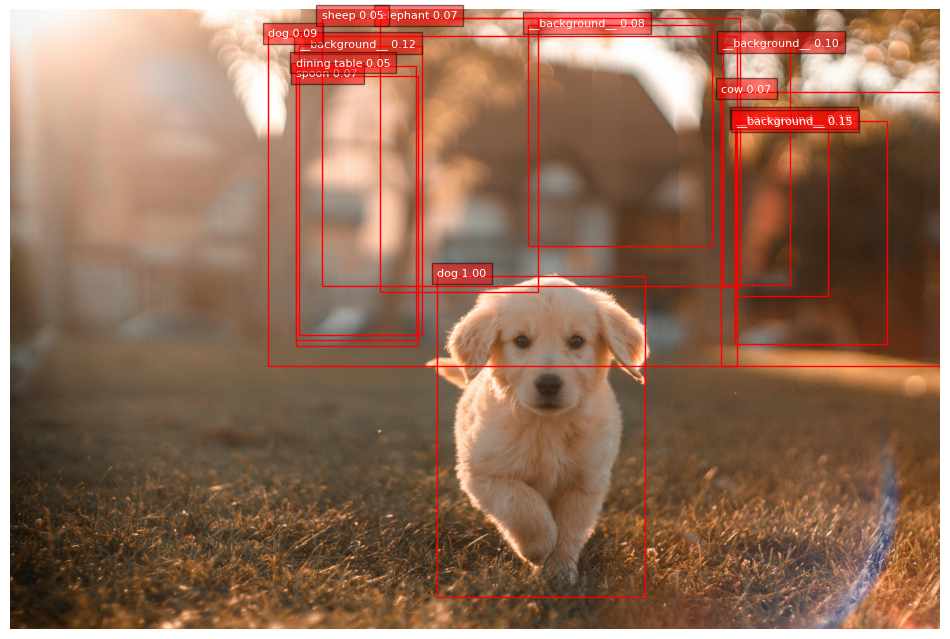

In [16]:
# Convert tensor image back to numpy for visualization
img = test_img_tensor.squeeze().detach().cpu().numpy()  # Adjust dimensions as necessary
img = img.transpose(1, 2, 0)  # Rearrange the dimensions from CxHxW to HxWxC for image display

# Create figure and axes
fig, ax = plt.subplots(1, figsize=(12, 9))

# Display the image
ax.imshow(img)

# Add bounding boxes and labels
for box, label, score in zip(preds[0]['boxes'], preds[0]['labels'], preds[0]['scores']):
    x1, y1, x2, y2 = box.detach().cpu().numpy()  # Make sure to detach and convert boxes as well
    label_name = COCO_INSTANCE_CATEGORY_NAMES[label.item()]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1, f'{label_name} {score.item():.2f}', color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')  # to turn off axes for better visualization
plt.show()

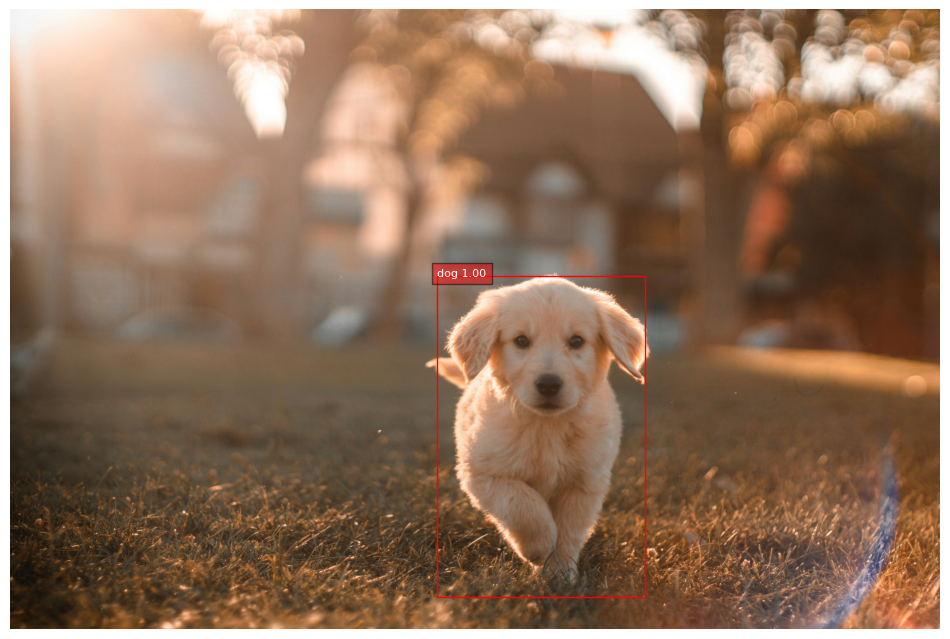

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set a threshold for displaying predictions
CONFIDENCE_THRESHOLD = 0.8  # for example, 50%

# Convert tensor image back to numpy for visualization
img = test_img_tensor.squeeze().detach().cpu().numpy()  # Adjust dimensions as necessary
img = img.transpose(1, 2, 0)  # Rearrange the dimensions from CxHxW to HxWxC for image display

# Create figure and axes
fig, ax = plt.subplots(1, figsize=(12, 9))

# Display the image
ax.imshow(img)

# Add bounding boxes and labels
for box, label, score in zip(preds[0]['boxes'], preds[0]['labels'], preds[0]['scores']):
    if score.item() > CONFIDENCE_THRESHOLD:
        x1, y1, x2, y2 = box.detach().cpu().numpy()  # Make sure to detach and convert boxes as well

        # Adjust for potential off-by-one error
        label_index = label.item()  # Assuming model's labels are 0-indexed
        # If labels are 1-indexed, subtract 1: label_index = label.item() - 1

        label_name = COCO_INSTANCE_CATEGORY_NAMES[label_index]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, f'{label_name} {score.item():.2f}', color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')  # to turn off axes for better visualization
plt.show()